In [1]:
# Подключаем необходимые модули
import family, sgd

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


seed_params = 123
seed_regressors = 10
seed_response = 4
seed_sgd = 1

In [2]:
def adj_r2(y, y_pred, n_params):
    n = len(y)
    error = y - y_pred
    r2 = 1 - np.sum(error**2) / np.sum((y - np.mean(y)) ** 2)
    return 1 - (1 - r2) * (n - 1) / (n - n_params - 1)

def pseudo_r2(y, y_pred, family: family.Family):
    d_fitted = family.deviance(y, y_pred) 
    d_null = family.deviance(y, np.mean(y))
    return 1 - d_fitted / d_null

## Проверка на сгенерированных данных


Пусть количество индивидов равно $n=1000$, количество признаков равно $p=10$ (без учета константы).


In [3]:
n, p = 1000, 10

In [4]:
# Генерация параметров
np.random.seed(seed_params)
params = np.random.uniform(-10, 10, p + 1)
print(params)

[ 3.92938371 -4.2772133  -5.46297093  1.02629538  4.3893794  -1.5378708
  9.61528397  3.69659477 -0.38136197 -2.15764964 -3.13643968]


In [5]:
# Генерация регрессоров
np.random.seed(seed_regressors)
X = np.random.rand(n, p)
# Константный член
X = sm.add_constant(X)
column_names = np.append("intercept", [f"x{i}" for i in range(1, p + 1)])

### 1. Линейная регрессия (Gaussian GLM)


Модель: зависимая переменная $\mathbf{y}$ распределена нормально и $$\mathsf E(\mathbf{y}~|~\mathbf{X})=\boldsymbol\mu=\mathbf{X}\boldsymbol\beta,$$ где $\mathbf{X}$ — матрица данных, $\boldsymbol\beta$ — вектор параметров. Плотность нормального распределения: $$p(y; \mu, \sigma^2)=\frac1{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(x-\mu)^2}{2\sigma^2}\right\},\quad y\in \mathbb{R},\quad \mu\in\mathbb{R},\,\sigma>0.$$

In [6]:
# Параметры нормального распределения
mu = X.dot(params)
sigma = 0.1

In [7]:
# Генерация отклика
np.random.seed(seed_response)
y1 = mu + np.random.normal(0, sigma, n)

In [8]:
np.random.seed(seed_sgd)
model1 = sgd.SGD(family=family.Gaussian(), lr=0.03, batch_size=16)
model1_pred = model1.fit(X, y1).predict(X)

In [9]:
result1 = pd.DataFrame(index=column_names)
result1["Estimated"] = model1.params
result1["True"] = params
print(
    result1,
    f"Epochs passed: {model1.n_iter}",
    f"Dispersion (scale) parameter: {model1.dispersion}",
    f"Adjusted R-squared: {adj_r2(y1, model1_pred, p)}",
    sep="\n",
)

           Estimated      True
intercept   3.935208  3.929384
x1         -4.254903 -4.277213
x2         -5.470059 -5.462971
x3          1.028168  1.026295
x4          4.379706  4.389379
x5         -1.544207 -1.537871
x6          9.620079  9.615284
x7          3.711597  3.696595
x8         -0.383994 -0.381362
x9         -2.180469 -2.157650
x10        -3.131106 -3.136440
Epochs passed: 69
Dispersion (scale) parameter: 0.008969032084244847
Adjusted R-squared: 0.9994550236678179


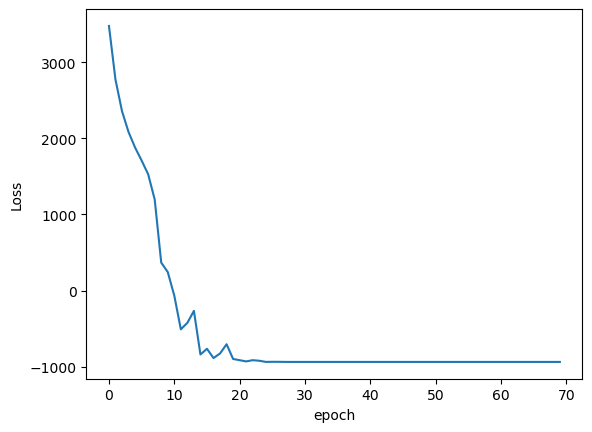

In [10]:
# График функции потерь
plt.plot(model1.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

### 2. Гамма-регрессия (Gamma GLM)

Модель: зависимая переменная $\mathbf{y}$ имеет гамма-распределение и $$\mathsf E(\mathbf{y}~|~\mathbf{X})=\boldsymbol\mu=e^{\mathbf{X}\boldsymbol\beta}.$$ Плотность гамма-распределения: $$p(y; k, \theta) = \frac{y^{k-1}}{\Gamma(k)\theta^k}\exp\left\{-\frac{y}{\theta}\right\},\quad y > 0,\quad k, \theta > 0.$$

In [11]:
# Параметры гамма-распределения
k = 10
mu = np.exp(X.dot(params))
theta = mu / k

In [12]:
# Генерация отклика
np.random.seed(seed_response)
y2 = np.random.gamma(k, theta, n)

In [13]:
np.random.seed(seed_sgd)
model2 = sgd.SGD(family=family.Gamma(), lr=0.03, batch_size=16)
model2_pred = model2.fit(X, y2).predict(X)

In [14]:
result2 = pd.DataFrame(index=column_names)
result2["Estimated"] = model2.params
result2["True"] = params
print(
    result2,
    f"Epochs passed: {model2.n_iter}",
    f"Dispersion (scale) parameter: {model2.dispersion}",
    f"Pseudo R-squared: {pseudo_r2(y2, model2_pred, family.Gamma())}",
    sep="\n",
)

           Estimated      True
intercept   3.941278  3.929384
x1         -4.263230 -4.277213
x2         -5.452918 -5.462971
x3          1.000984  1.026295
x4          4.324310  4.389379
x5         -1.535370 -1.537871
x6          9.645510  9.615284
x7          3.712122  3.696595
x8         -0.379930 -0.381362
x9         -2.164776 -2.157650
x10        -3.133490 -3.136440
Epochs passed: 82
Dispersion (scale) parameter: 0.09237087034754578
Pseudo R-squared: 0.9922403973070514


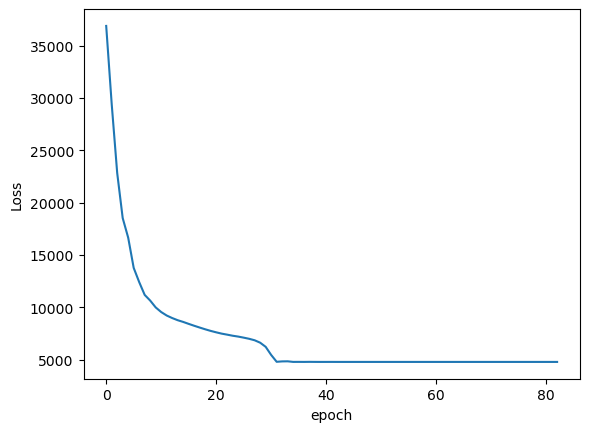

In [15]:
plt.plot(model2.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

## Реальные данные


In [16]:
# Загрузка данных
df = pd.read_csv("data/Real estate.csv", sep=",")
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [17]:
# Переименуем столбцы и выкинем столбец "No"
df.rename(
    columns={
        "X1 transaction date": "transact_date",
        "X2 house age": "house_age",
        "X3 distance to the nearest MRT station": "distance_nearest",
        "X4 number of convenience stores": "n_stores",
        "X5 latitude": "lat",
        "X6 longitude": "lon",
        "Y house price of unit area": "price",
    },
    inplace=True,
)
df.drop("No", axis=1, inplace=True)
df.head(5)

,transact_date,house_age,distance_nearest,n_stores,lat,lon,price
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [18]:
# Размеры датасета
df.shape

(414, 7)

In [19]:
# Описательная статистика, проверка на некорректные данные
df.describe()

,transact_date,house_age,distance_nearest,n_stores,lat,lon,price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


<Axes: ylabel='Count'>

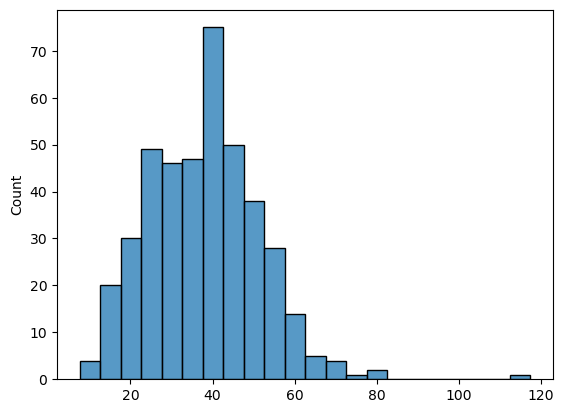

In [20]:
# Зависимая переменная
target = df.price.to_numpy()
df.drop("price", axis=1, inplace=True)

sns.histplot(target)

In [21]:
# Перед применением стандартизуем данные
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df)

# Добавляем константну
df_scaled = sm.add_constant(df_scaled)

columns = np.append("intercept", df.columns)

Обучим линейную регрессию и GLM с гамма-распределением.

### 1. Линейная регрессия

In [22]:
np.random.seed(seed_sgd)
lm = sgd.SGD(family=family.Gaussian(), lr=0.1, batch_size=16)
lm_pred = lm.fit(df_scaled, target).predict(df_scaled)

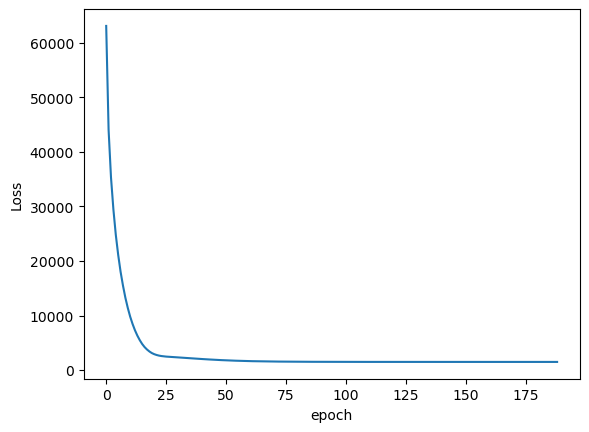

In [23]:
plt.plot(lm.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

Сравним полученные результаты с SGDRegressor из библиотеки `sklearn`.

In [24]:
from sklearn.linear_model import SGDRegressor
np.random.seed(seed_sgd)
lm_sklearn = SGDRegressor(learning_rate="adaptive", eta0=0.1, penalty=None, fit_intercept=False)
lm_sklearn_pred = lm_sklearn.fit(df_scaled, target).predict(df_scaled)

In [25]:
lm_comparison = pd.DataFrame(index=np.append(columns, "Adjusted R-squared"))
lm_comparison["SDG"] = np.append(lm.params, adj_r2(target, lm_pred, df.shape[1]))
lm_comparison["SGDRegressor"] = np.append(lm_sklearn.coef_, adj_r2(target, lm_sklearn_pred, df.shape[1]))

print(lm_comparison)

                          SDG  SGDRegressor
intercept           37.976997     37.985638
transact_date        1.446827      1.461966
house_age           -3.055246     -3.070485
distance_nearest    -5.660887     -5.635479
n_stores             3.373381      3.339555
lat                  2.809412      2.805714
lon                 -0.187202     -0.177384
Adjusted R-squared   0.576197      0.576212


### 2. Гамма-регрессия

In [26]:
np.random.seed(seed_sgd)
glm = sgd.SGD(family=family.Gamma(), lr=0.01, batch_size=16)
glm_pred = glm.fit(df_scaled, target).predict(df_scaled)

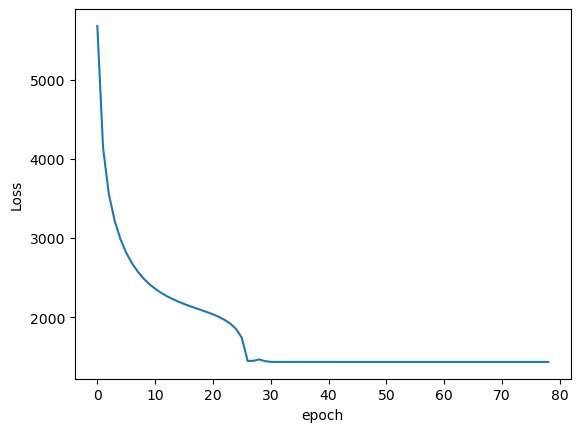

In [27]:
plt.plot(glm.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

Сравним полученные результаты с GLM из библиотеки `statmodels`.

In [28]:
glm_sm = sm.GLM(target, df_scaled, family=sm.families.Gamma(sm.families.links.Log()))
results = glm_sm.fit()

In [29]:
glm_comparison = pd.DataFrame(index=np.append(columns, ["Dispersion (scale) parameter", "Pseudo R-squared"]))
glm_comparison["SGD"] = np.append(glm.params, [glm.dispersion, pseudo_r2(target, glm_pred, family.Gamma())])
glm_comparison["GLM"] = np.append(results.params, [results.scale, pseudo_r2(target, results.predict(df_scaled), family.Gamma())])

print(glm_comparison)

                                   SGD       GLM
intercept                     3.591820  3.590622
transact_date                 0.046941  0.045534
house_age                    -0.073330 -0.073809
distance_nearest             -0.199475 -0.198254
n_stores                      0.074807  0.074781
lat                           0.087781  0.088450
lon                          -0.004894 -0.004029
Dispersion (scale) parameter  0.048081  0.053814
Pseudo R-squared              0.659948  0.659976
